In [36]:
import zipfile
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
zip_ref=zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-09-22 20:48:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  22.0MB/s    in 23s     

2023-09-22 20:49:02 (21.1 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [37]:
train_dir="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [38]:
import os
for dirpath, dirnames, filenames in os.walk(train_dir):
  class_names=dirnames
  break
class_names

['steak',
 'sushi',
 'ice_cream',
 'ramen',
 'grilled_salmon',
 'pizza',
 'fried_rice',
 'chicken_curry',
 'hamburger',
 'chicken_wings']

In [39]:
# preproccessing the data for the cnn model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data=train_datagen.flow_from_directory(train_dir,
                                             target_size=(244,244),
                                             class_mode="categorical",
                                             batch_size=32)

test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=(244,244),
                                           class_mode="categorical",
                                           batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [40]:
from keras.src import optimizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D ,MaxPool2D,Flatten,Dense

food_model=Sequential([
    Conv2D(10,3,input_shape=(244,244,3),activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),

    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),

    Flatten(),
    Dense(10,activation="softmax")
])

food_model.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics="accuracy")

history=food_model.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(test_data))


Epoch 1/5
235/235 [==============================] - 37s 147ms/step - loss: 2.2346 - accuracy: 0.1676 - val_loss: 2.0924 - val_accuracy: 0.2220
Epoch 2/5
235/235 [==============================] - 30s 127ms/step - loss: 2.0024 - accuracy: 0.2920 - val_loss: 1.9538 - val_accuracy: 0.3008
Epoch 3/5
235/235 [==============================] - 28s 119ms/step - loss: 1.7716 - accuracy: 0.3935 - val_loss: 1.8629 - val_accuracy: 0.3504
Epoch 4/5
235/235 [==============================] - 30s 128ms/step - loss: 1.3007 - accuracy: 0.5689 - val_loss: 2.1506 - val_accuracy: 0.3088
Epoch 5/5
235/235 [==============================] - 30s 128ms/step - loss: 0.5920 - accuracy: 0.8124 - val_loss: 2.6792 - val_accuracy: 0.2896


In [41]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

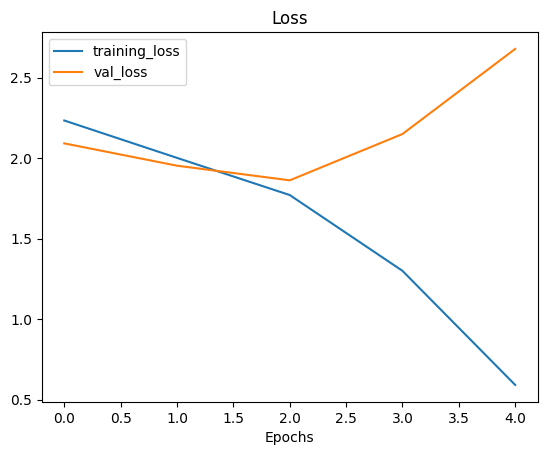

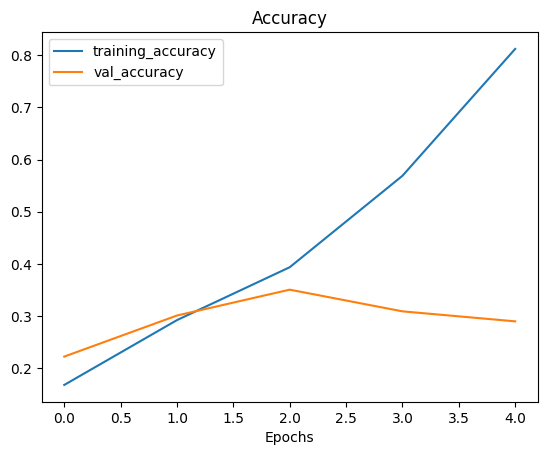

In [42]:
plot_loss_curves(history)


# graphs show us that our model is overfitting

In [43]:
# Data Augmentation

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [49]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [48]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);